In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Reshape, UpSampling2D, Conv2D
from tensorflow.keras.layers import Activation, LeakyReLU, Dropout, Flatten

2023-10-23 13:16:04.378137: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [3]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28, 28, 1), padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [4]:
# 생성자와 판별자 모델을 연결시키는 gan 모델 만들기
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    


                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1078146 (4.11 MB)
Trainable params: 852609 (3.25 MB)
Non-trainable params: 225537 (881.00 KB)
_________________________________________________________________


In [7]:
# 신경망을 실행시키는 함수 만들기
def gan_train(epoch, batch_size, saving_interval):
  (X_train, _), (_, _) = mnist.load_data()

  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

  X_train = (X_train - 127.5) / 127.5

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    d_loss_real = discriminator.train_on_batch(imgs, true)

    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    g_loss = gan.train_on_batch(noise, true)

    print('epoch:%d' % i, ' d_loss : %.4f' % d_loss, 'g_loss : %.4f' % g_loss)

    if i % saving_interval == 0:
      noise = np.random.normal(0, 1, (25, 100))
      gen_imgs = generator.predict(noise)
      gen_imgs = 0.5 * gen_imgs + 0.5

      fig, axs = plt.subplots(5, 5)
      count = 0
      for j in range(5):
        for k in range(5):
          axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
          axs[j, k].axis('off')
          count += 1
          fig.savefig('../gan_images%d.png' % i)

1/1 [==============================] - 0s 33ms/step
epoch:0  d_loss : 0.4001 g_loss : 0.5627
1/1 [==============================] - 0s 30ms/step
epoch:1  d_loss : 0.3376 g_loss : 0.1359
1/1 [==============================] - 0s 30ms/step
epoch:2  d_loss : 0.3419 g_loss : 0.0301
1/1 [==============================] - 0s 31ms/step
epoch:3  d_loss : 0.4682 g_loss : 0.0085
1/1 [==============================] - 0s 31ms/step
epoch:4  d_loss : 0.5512 g_loss : 0.0118
1/1 [==============================] - 0s 30ms/step
epoch:5  d_loss : 0.5522 g_loss : 0.0746
1/1 [==============================] - 0s 33ms/step
epoch:6  d_loss : 0.6217 g_loss : 0.3063
1/1 [==============================] - 0s 33ms/step
epoch:7  d_loss : 0.5820 g_loss : 0.6020
1/1 [==============================] - 0s 33ms/step
epoch:8  d_loss : 0.7988 g_loss : 0.5155
1/1 [==============================] - 0s 38ms/step
epoch:9  d_loss : 0.6784 g_loss : 0.4561
1/1 [==============================] - 0s 41ms/step
epoch:10  d_loss :

/var/folders/_6/2zcx5d0s79379ny3_nmcwpv40000gn/T/ipykernel_1273/434202937.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(5, 5)


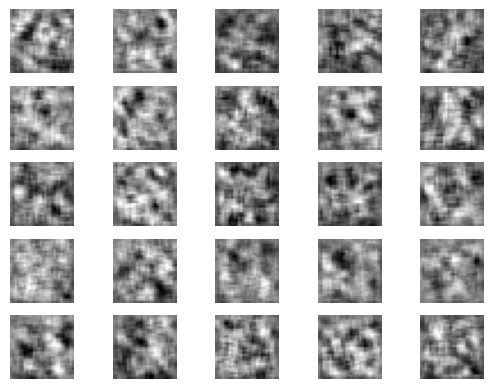

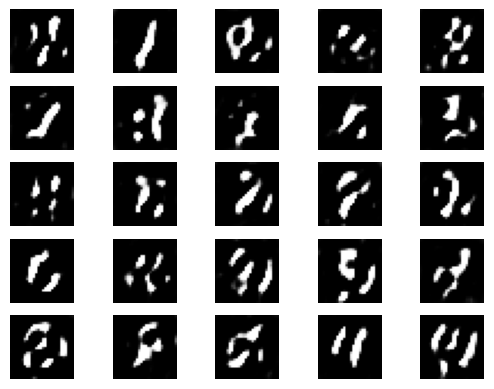

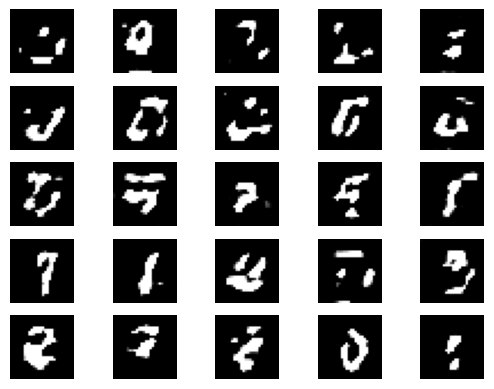

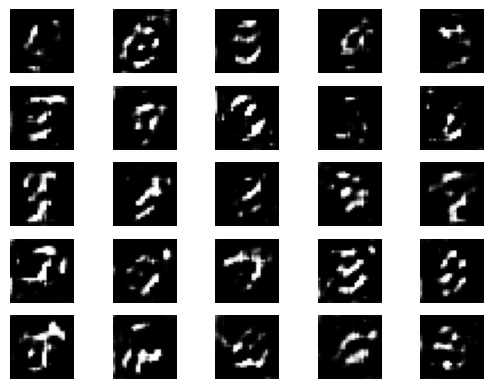

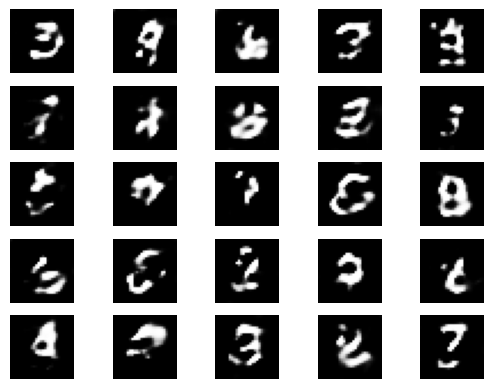

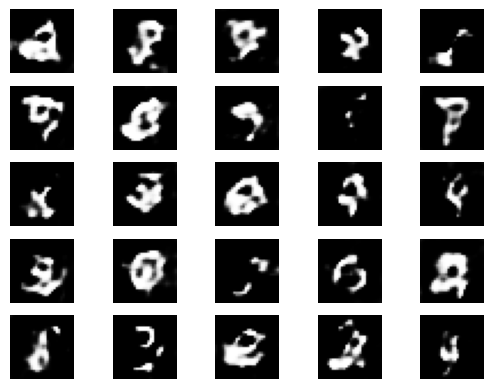

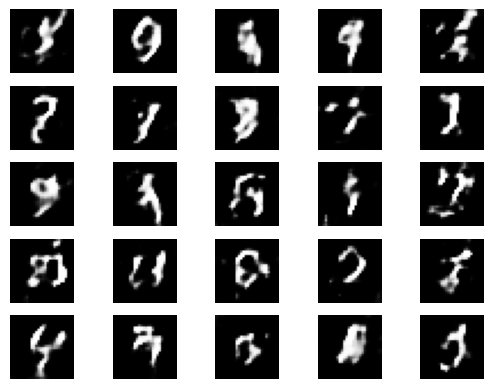

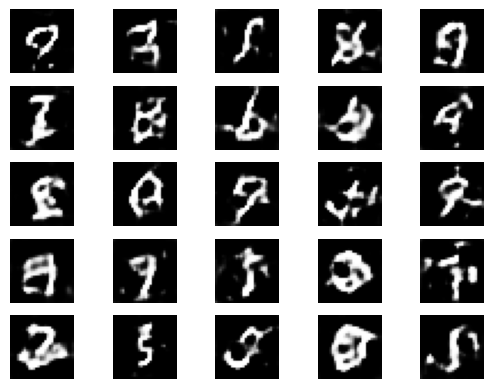

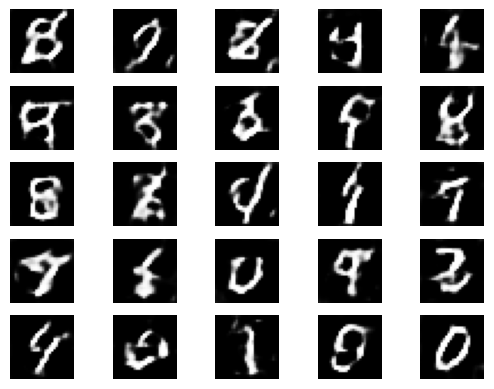

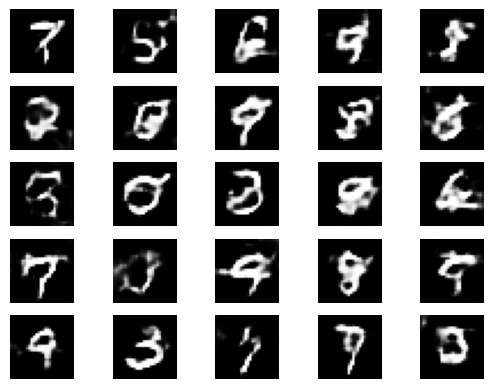

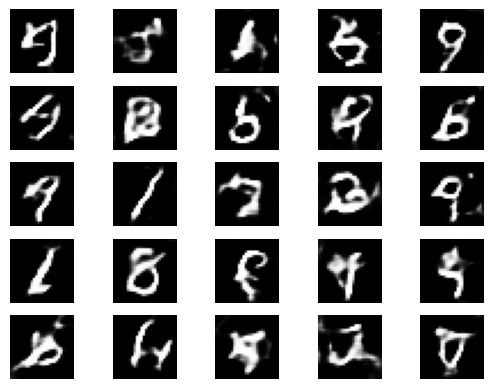

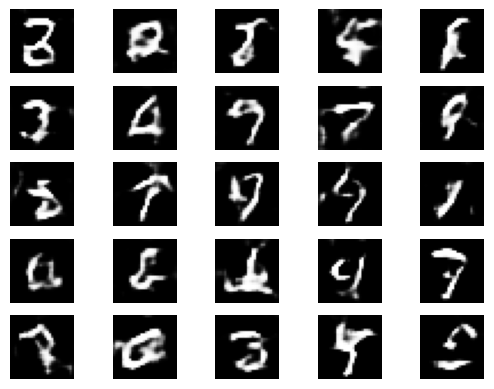

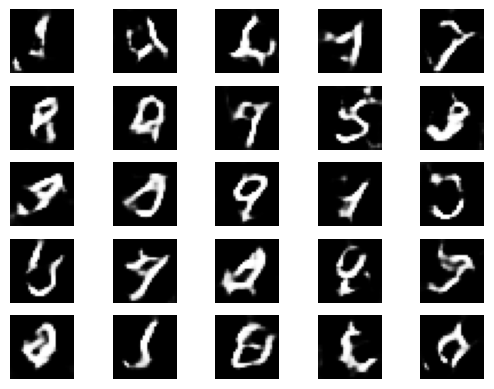

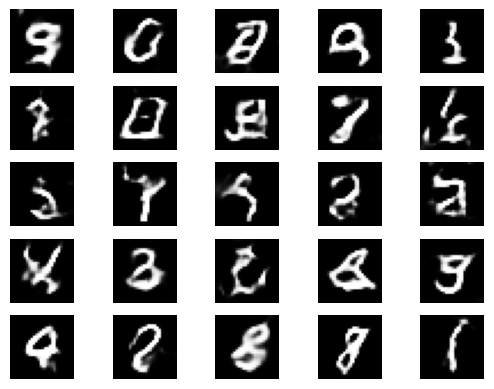

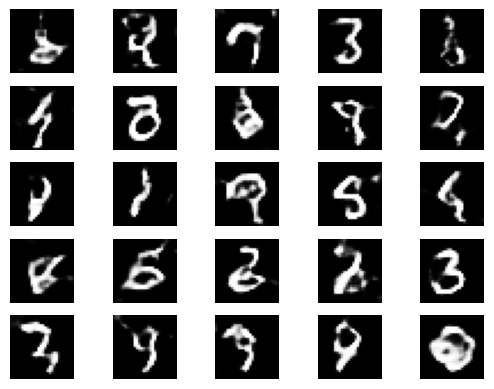

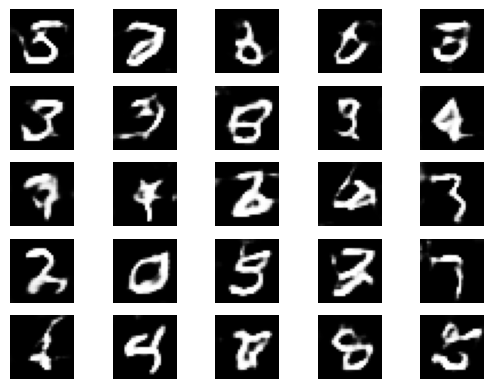

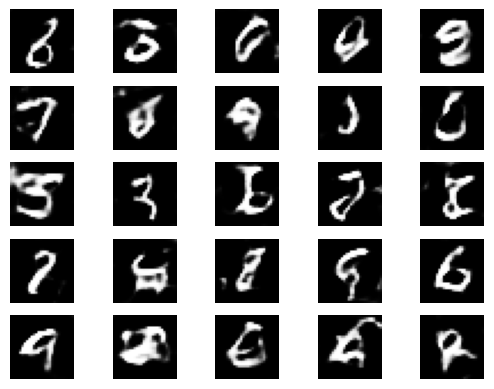

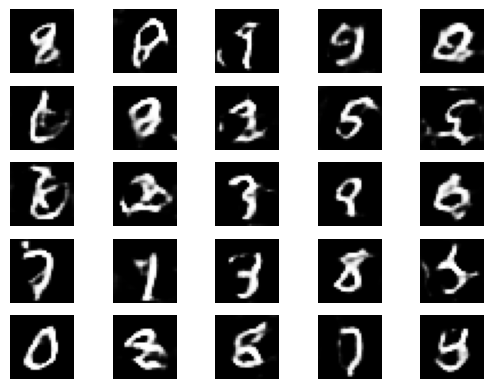

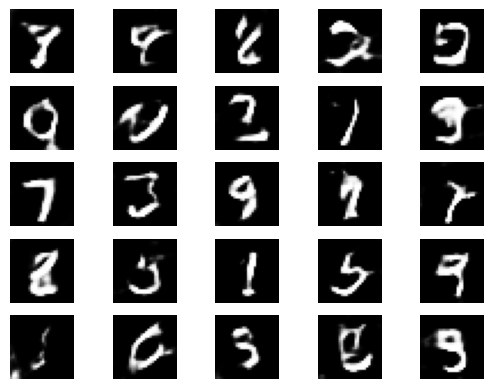

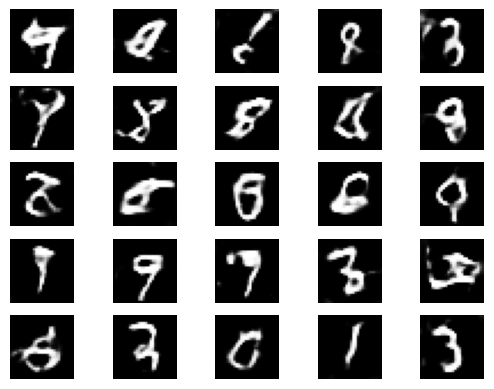

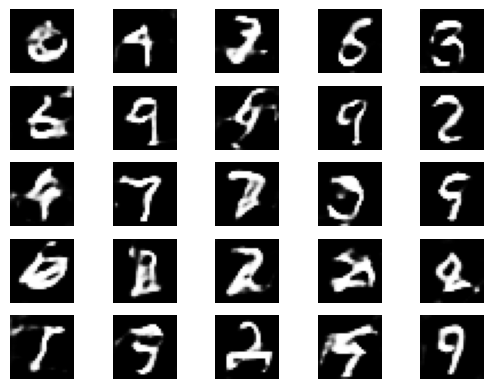

In [8]:
gan_train(4001, 32, 200)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 8)          

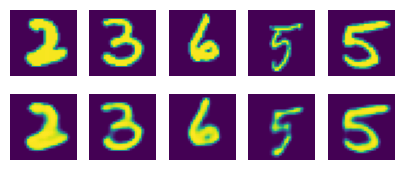

In [9]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
import matplotlib.pyplot as plt

# MNIST데이터 셋을 호출
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

# 생성자 모델 만들기
autoencoder = Sequential()

# 인코딩 부분
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

# 디코딩 부분
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

# 전체 구조 확인
autoencoder.summary()

# 컴파일 및 학습을 하는 부분
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

# 학습된 결과를 출력하는 부분
random_test = np.random.randint(X_test.shape[0], size=5)  # 테스트할 이미지를 랜덤으로 호출.
ae_imgs = autoencoder.predict(X_test)  # 앞서 만든 오토인코더 모델에 집어넣이기

plt.figure(figsize=(7, 2))  # 출력될 이미지의 크기를 정하기

for i, image_idx in enumerate(random_test):    # 랜덤으로 뽑은 이미지를 차례로 나열
   ax = plt.subplot(2, 7, i + 1)
   plt.imshow(X_test[image_idx].reshape(28, 28))  # 테스트할 이미지를 먼저 그대로 보여줌
   ax.axis('off')
   ax = plt.subplot(2, 7, 7 + i +1)
   plt.imshow(ae_imgs[image_idx].reshape(28, 28))  # 오토인코딩 결과를 다음 열에 입력
   ax.axis('off')
plt.show()